In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import img_as_float
from skimage import io, util, filters, metrics

In [2]:
img1 = io.imread("GRBG.png")
img2 = io.imread("ColorChecker.png")

In [3]:
def toGRBG(arr):
    return [arr[1], (int(arr[0]) + int(arr[3]))//2, arr[2]]

def superPixel(img, mode):
    out = np.ones((len(img) // 2, len(img[0]) // 2, 3))
    m = 0
    n = 0
    for i in range(0, len(img), 2):
        n = 0
        for j in range(0, len(img[i]), 2):
            if i + 2 >= len(img) or j + 2 >= len(img[i]): break
            else:
                if mode == "GRBG":
                    out[m][n] = toGRBG(img[i:i+2, j:j+2].reshape(-1, 4)[0])
                else:
                    print("Указан неверный режим работы.")
                    return 0
            n += 1
        m += 1

    return np.int16(out)

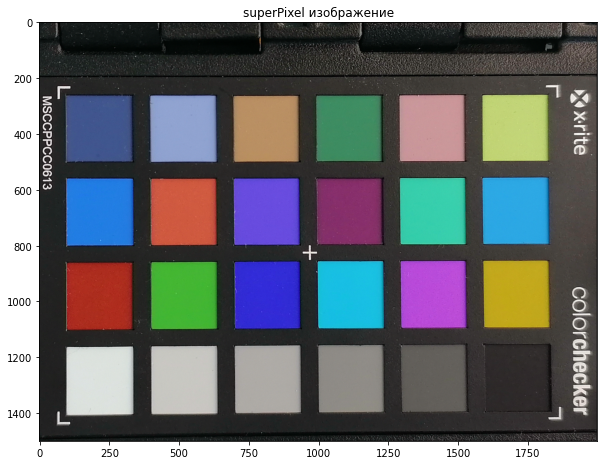

In [4]:
img1Pix = superPixel(img1, "GRBG")

fig, axes = plt.subplots(1,1)
fig.set_figwidth(10)
fig.set_figheight(10)

axes.set_title('superPixel изображение')
axes.imshow(img1Pix, cmap='gray')

# io.imsave("syperpyper.png", img1Pix.astype(np.uint8))

In [5]:
def imPad(image):
    extra_col_left = [el[1] for el in [i for i in image]]
    image = np.c_[extra_col_left, image]
    image = np.r_[image[1].reshape(1, -1), image]

    extra_col_right = [el[-2] for el in [i for i in image]]
    image = np.c_[image, extra_col_right]
    image = np.r_[image, image[-2].reshape(1, -1)]

    image[0][0] = image[2][2]
    image[0][-1] = image[2][-3]
    image[-1][-1] = image[-3][-3]
    image[-1][0] = image[-3][2]

    return image


def R_(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 4

    #R
    R = gray_image[target_y][target_x]

    #G
    G = 0
    G += gray_image[target_y][target_x - 1]
    G += gray_image[target_y - 1][target_x]
    G += gray_image[target_y][target_x + 1]
    G += gray_image[target_y + 1][target_x]
    G = int(G / delit)

    #B
    B = 0
    B += gray_image[target_y - 1][target_x - 1]
    B += gray_image[target_y - 1][target_x + 1]
    B += gray_image[target_y + 1][target_x + 1]
    B += gray_image[target_y + 1][target_x - 1]
    B = int(B / delit)

    return R, G, B


def G_first(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 2

    #G
    G = gray_image[target_y][target_x]

    #R
    R = 0
    R += gray_image[target_y][target_x - 1]
    R += gray_image[target_y][target_x + 1]
    R = int(R / delit)

    #B
    B = 0
    B += gray_image[target_y - 1][target_x]
    B += gray_image[target_y + 1][target_x]
    B = int(B / delit)
    return R, G, B


def G_second(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 2

    #G
    G = gray_image[target_y][target_x]

    #R
    R = 0
    R += gray_image[target_y - 1][target_x]
    R += gray_image[target_y + 1][target_x]
    R = int(R / delit)

    #B
    B = 0
    B += gray_image[target_y][target_x - 1]
    B += gray_image[target_y][target_x + 1]
    B = int(B / delit)
    return R, G, B

def B_(gray_image, index_1, index_2):
    target_y = index_1
    target_x = index_2
    delit = 4

    #B
    B = gray_image[target_y][target_x]

    #G
    G = 0
    G += gray_image[target_y][target_x - 1]
    G += gray_image[target_y - 1][target_x]
    G += gray_image[target_y][target_x + 1]
    G += gray_image[target_y + 1][target_x]
    G = int(G / delit)

    #R
    R = 0
    R += gray_image[target_y - 1][target_x - 1]
    R += gray_image[target_y - 1][target_x + 1]
    R += gray_image[target_y + 1][target_x + 1]
    R += gray_image[target_y + 1][target_x - 1]
    R = int(R / delit)

    return R, G, B

def bilinear_interpolation(image):
    color_image = []

    for rows_ind in range(len(image[1:-1])):
        if rows_ind % 2 == 0:
            first_row = []

            for cols_ind in range(len(image[rows_ind + 1][1:-1])):
                RGB = { 'r': 0, 'g': 0, 'b': 0 }
                if cols_ind % 2 == 0:
                    RGB['r'], RGB['g'], RGB['b'] = R_(image, rows_ind + 1, cols_ind + 1)
                    first_row.append(list(RGB.values()))
                    continue
                RGB['r'], RGB['g'], RGB['b'] = G_first(image, rows_ind + 1, cols_ind + 1)
                first_row.append(list(RGB.values()))
            color_image.append(first_row)
            continue

        second_row = []

        for cols_ind in range(len(image[rows_ind + 1][1:-1])):
            RGB = { 'r': 0, 'g': 0, 'b': 0 }
            if cols_ind % 2 == 0:
                RGB['r'], RGB['g'], RGB['b'] = G_second(image, rows_ind + 1, cols_ind + 1)
                second_row.append(list(RGB.values()))
                continue
            RGB['r'], RGB['g'], RGB['b'] = B_(image, rows_ind + 1, cols_ind + 1)
            second_row.append(list(RGB.values()))
        color_image.append(second_row)

    return np.array(color_image)

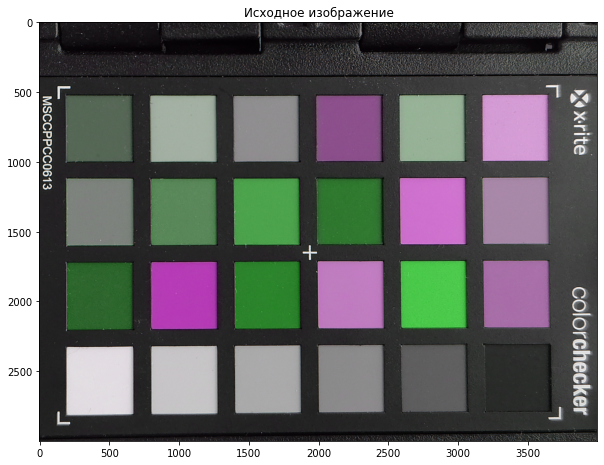

In [6]:
img1BI = bilinear_interpolation(imPad(img1))

fig, axes = plt.subplots(1,1)
fig.set_figwidth(10)
fig.set_figheight(10)

axes.set_title('Исходное изображение')
axes.imshow(img1BI, cmap='gray')

# io.imsave("debilization.png", img1BI.astype(np.uint8))

In [7]:
def shrek(image1, image2):
    image_float = img_as_float(image1)
    noise_float = img_as_float(image2)

    mse = metrics.mean_squared_error(image_float, noise_float)
    psnr = metrics.peak_signal_noise_ratio(image_float, noise_float)
    ssim = metrics.structural_similarity(image_float, noise_float, multichannel=True, channel_axis=2)

    print(f"MSE = {round(mse,5)}")
    print(f"PSNR = {round(psnr,5)}")
    print(f"SSIM = {round(ssim,5)}\n")

In [8]:
img1Pix=cv2.resize(img1Pix, (4000, 3000), interpolation=cv2.INTER_NEAREST)

shrek(img1Pix, img2)
shrek(img1BI, img2)


C:\Users\serku\AppData\Local\Temp\ipykernel_14536\1120502903.py:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(image_float, noise_float, multichannel=True, channel_axis=2)


MSE = 0.17842
PSNR = 7.48557
SSIM = 0.03302

MSE = 0.1808
PSNR = 7.42798
SSIM = 0.01669

